In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/sample_submission.csv
/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/train_dataset.csv
/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/test_dataset.csv
/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/val_dataset.csv


In [2]:
#Εισαγωγή βιβλιοθηκών
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
print("Done!")

2025-05-17 17:37:50.222970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747503470.409223      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747503470.463833      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Done!


In [3]:
# Φόρτωση δεδομένων
train_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/train_dataset.csv")
val_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/val_dataset.csv")
test_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-3/test_dataset.csv")

print("Done!")


Done!


In [4]:
import re
#Προεπεξεργασία δεδομένων
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)     # remove mentions
    text = re.sub(r"[^a-zA-Z']", " ", text)  # keep only letters and apostrophes
    text = text.lower()
    return text

# Apply cleaning
train_df['cleaned'] = train_df['Text'].apply(clean_text)
val_df['cleaned'] = val_df['Text'].apply(clean_text)
test_df['cleaned'] = test_df['Text'].apply(clean_text)

print("Done cleaning!")

Done cleaning!


In [5]:
#BertTokenizer και ορισμός συνάρτησης tokenize_data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(texts, labels=None):
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=128)
    if labels is not None:
        encodings['labels'] = labels.tolist()
    return encodings

print("Done tokenizing!")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Done tokenizing!


In [6]:
#Ορισμός custom Dataset
class TweetDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

In [7]:
#Pretraining data με συναρτήσεις που ορίσαμε παραπάνω
train_enc = tokenize_data(train_df['Text'], train_df['Label'])
val_enc = tokenize_data(val_df['Text'], val_df['Label'])

train_dataset = TweetDataset(train_enc)
val_dataset = TweetDataset(val_enc)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [8]:
#Φόρτωση μοντέλου BERT
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

num_training_steps = len(train_loader) * 2  # 2 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

train_losses = []
val_losses = []
val_accuracies = []

model.train()
epochs = 2

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    total_loss = 0

    model.train()
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            labels = batch['labels'].to(device)
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)

            loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(acc)

    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Accuracy: {acc:.4f}")



Epoch 1/2


100%|██████████| 9275/9275 [31:01<00:00,  4.98it/s]


Train Loss: 0.3742 | Val Loss: 0.3352 | Val Accuracy: 0.8529

Epoch 2/2


100%|██████████| 9275/9275 [31:03<00:00,  4.98it/s]


Train Loss: 0.2547 | Val Loss: 0.3492 | Val Accuracy: 0.8561


In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Προετοιμασία και ορισμός συνάρτησης για τη φόρτωση του μοντέλου
def evaluate(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            labels = batch['labels'].to(device)
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

    print(f"\n✅ Validation Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")
    return acc, precision, recall, f1

# Εκτέλεση αξιολόγηση/φόρτωση του μοντέλου
evaluate(model, val_loader)
print("Done evaluation!")


✅ Validation Accuracy: 0.8561
Precision: 0.8592 | Recall: 0.8519 | F1-score: 0.8555
Done evaluation!


In [11]:
# Προετοιμασία test set
test_encodings = tokenizer(test_df['cleaned'].tolist(), truncation=True, padding=True, max_length=128)
test_dataset = TweetDataset(test_encodings)  # fake labels, θα τα αγνοήσει
test_loader = DataLoader(test_dataset, batch_size=32)
print("Done prepro TestSet!")

Done prepro TestSet!


In [12]:
# Πρόβλεψη
model.eval()
test_preds = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items() if k != 'labels'}

        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        test_preds.extend(preds.cpu().numpy())


# Δημιουργία τελικού submission αρχείου
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'Label': test_preds
})
submission.to_csv("submission.csv", index=False)
print("Done t")

Done t


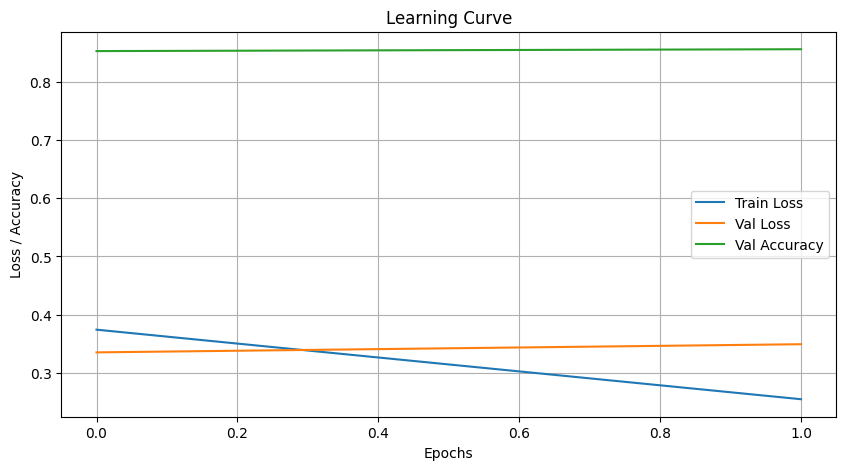

In [13]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()


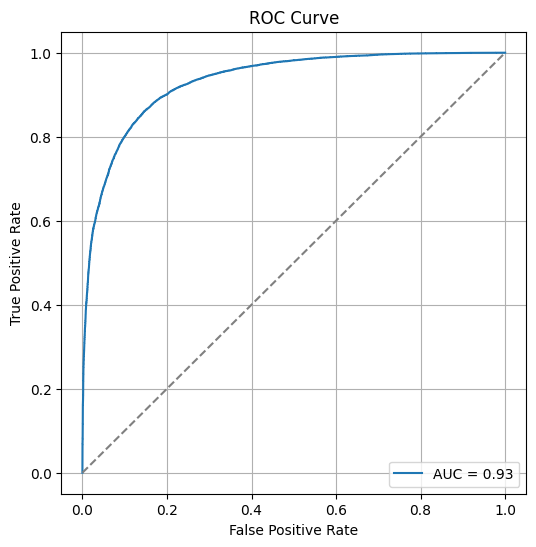

In [14]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


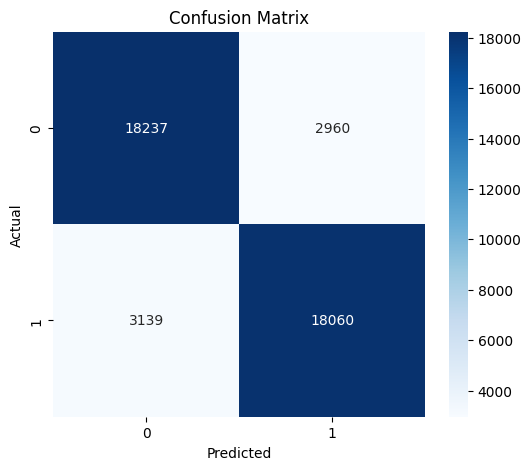

In [15]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
